In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv("/datasets/sberbank-russian-housing-market/train.csv", index_col=0)
df_macro = pd.read_csv("/datasets/sberbank-russian-housing-market/macro.csv")

In [3]:
# dropping na's and processing ONLY for the forward stepwise
X_train.dropna(inplace=True)
X_train.reset_index(inplace=True)
X_train.drop(columns=["id"], inplace=True)
X_train = X_train.select_dtypes(include=np.number)

In [4]:
y_train = X_train[["price_doc"]]
X_train = X_train.drop("price_doc", axis = 1)

In [6]:
X_train_sample = X_train[["full_sq", "life_sq","floor"]].fillna(0).sample(5000)
y_train_sample = y_train.loc[X_train_sample.index]

In [68]:
y_train_sample = y_train_sample/1000000

In [69]:
y_train_sample

,price_doc
16826,6.500000
28971,4.657415
6980,5.851250
5029,6.650000
1370,18.327100
...,...
29178,3.713450
29789,9.100000
16673,8.308714
30185,8.972619


## Neural Network

In [80]:
class NeuralNetwork():
    def fit(self, X, y, n_hidden, nodes, activations, lr):
        self._lr = lr
        self._X = X.values
        self._y = y.values
        self._n_hidden = n_hidden
        self._nodes = nodes
        self._weights = self._generate_weights()
        self._biases = self._generate_bias()
        self._activations = activations
        self._forward_inputs = []
        
        self._train()
        
    def _activation(self, data, activation = "relu"):
        if activation == "relu":
            def relu(data):
                return np.array([max(0,i) for i in data]).reshape(data.shape)
            return np.apply_along_axis(relu, 1, data)
        if activation == "sigmoid":
            def sigmoid(data):
                return (1/(1 + np.exp(-data))).reshape(data.shape)
            return np.apply_along_axis(sigmoid, 1, data)
    
    def _der_activation(self, points, activation = "relu"):
        if activation == "relu":
            def d_relu(point):
                return np.array([0 if y <= 0 else 1 for y in point])
            return np.apply_along_axis(d_relu, 1, points)
        if activation == "sigmoid":
            ## todo
            return
    
    def _loss_function(self, ypred, loss = "l2"):
        if loss == "mse":
            return ((ypred - self._y) ** 2).mean()
        if loss == "l2":
            return (((ypred - self._y) ** 2)/2)
    
    def _loss_jacobian(self, ypred, loss = "l2"):
        if loss == "l2":
            return (ypred - self._y)/(len(ypred))
    
    def _generate_weights(self):
        hidden_weights = []
        nodes = self._nodes
        for idx in range(1,len(nodes)):
            hidden_weights.append(0.01 * np.random.randn(nodes[idx -1], nodes[idx]))

        return hidden_weights
    
    def _generate_bias(self):
        hidden_layers = []
        nodes = self._nodes
        for i in range(self._n_hidden + 1):
            hidden_layers.append(np.zeros((nodes[i + 1], 1)))
        return hidden_layers
    
    def _forward_propagation(self):
        """
        Suppose 2 observations
        
        Suppose previous layer is 3 nodes
        Suppose current layer is 2 nodes
        
        prev shape (2,3)
        prev = ob1 [prev_node_1 val, prev_node_2 val, prev_node_3 val]
               ob2 [prev_node_1 val, prev_node_2 val, prev_node_3 val]
               
        layer shape (3,2)
        layer = [weight for current_node_1 for prev_node_1, weight for current_node_2 for prev_node_1]
                [weight for current_node_1 for prev_node_2, weight for current_node_2 for prev_node_2]
                [weight for current_node_1 for prev_node_3, weight for current_node_2 for prev_node_3]
                
        output shape (2,2) # since 2 observations and 2 layers
        output = ob1 [current_node_1 val, current_node_2 val]
                 ob2 [current_node_1 val, current_node_2 val]
                 
        Then for bias in current layer it is (2,1) since 2 nodes in current layer
        
        So for each row in output we add the bias row wise and apply the activation function to each row
        
        prev <- ouput
        
        Move onto next layer...
        """
        prev = self._X
        weights = self._weights
        biases = self._biases
        activations = self._activations[1:-1]
    
        for idx, layer in enumerate(weights):
            if idx == (len(weights) - 1):
                self._forward_inputs.append((prev, None))
                prev = (prev @ layer) + biases[idx].T,
            else:
                weight_output = (prev @ layer) + biases[idx].T
                self._forward_inputs.append((prev, weight_output))
                prev = self._activation(data = weight_output, activation = activations[idx])

        return prev
    
    def _backward_propagation(self, ypred):
        j = self._loss_jacobian(ypred)
        #print("\nj\n")
        #print(j)
                
        for i in range(len(self._forward_inputs)-1, -1, -1):
            if i != (len(self._forward_inputs) - 1):
                # activation func on all layers except the last
                der_acti = self._der_activation(self._forward_inputs[i][1])
                j = np.multiply(j,der_acti)

            x = self._forward_inputs[i][0]
            #print("\nx:")
            #print(x)
            jw = x.T.dot(j)
            #print("\nweights before:")
            #print(self._weights[i])
            self._weights[i] -= self._lr * jw
            #print("\nweights after:")
            #print(self._weights[i])
            # todo: update bias
            j = j.dot(self._weights[i].T)
            
        self._forward_inputs = []
        
    
    def _train(self):
        for i in range(0, 100):
            out = self._forward_propagation()
            loss = self._loss_function(out[0])
            mse = self._loss_function(out[0], loss = "mse")
            print("\nloss:")
            print(self._loss_function(out[0]).mean())
            print("nmse:")
            print(mse)
            #print("\npredictions\n")
            #print(out)
            self._backward_propagation(out[0])

In [81]:
INPUT_SIZE = X_train_sample.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001
nodes = [INPUT_SIZE,50,OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]

nn = NeuralNetwork()

nn.fit(X = X_train_sample,
       y = y_train_sample,
       n_hidden = len(nodes) - 2,
       nodes = nodes,
       activations = activations,
       lr = LEARNING_RATE)


loss:
37.68895810752857
nmse:
75.37791621505714

loss:
35.92765305090365
nmse:
71.8553061018073

loss:
32.64316179440443
nmse:
65.28632358880886

loss:
27.39337281629731
nmse:
54.78674563259462

loss:
23.286256232158642
nmse:
46.572512464317285

loss:
22.013669995923006
nmse:
44.02733999184601

loss:
21.21967247536317
nmse:
42.43934495072634

loss:
20.431768908347312
nmse:
40.863537816694624

loss:
19.64663463553195
nmse:
39.2932692710639

loss:
18.870810330410716
nmse:
37.74162066082143

loss:
18.11700855348271
nmse:
36.23401710696542

loss:
17.395778307104813
nmse:
34.791556614209625

loss:
16.728202629564638
nmse:
33.456405259129276

loss:
16.132053090240756
nmse:
32.26410618048151

loss:
15.63997621709854
nmse:
31.27995243419708

loss:
15.238226845308311
nmse:
30.476453690616623

loss:
14.912118820783714
nmse:
29.82423764156743

loss:
14.658356209590307
nmse:
29.316712419180615

loss:
14.477137667626126
nmse:
28.95427533525225

loss:
14.350366373369415
nmse:
28.70073274673883

los

In [5]:
def solve_for_B(x, y, n):
    # takes a data frame, and a numpy array
    x = np.concatenate((np.ones((n,1)), x.to_numpy()), axis=1)
    x_transpose = np.transpose(x)
    return np.linalg.solve(np.matmul(x_transpose, x), x_transpose @ y)

def get_predicted_values(beta, design_matrix, n):
    return np.matmul(np.concatenate((np.ones((n,1)), design_matrix), axis = 1), beta)

def BIC(predictions, actuals, d, n):
    # numpy array - predictions, numpy array - actual 
    return (np.square(actuals - predictions).sum()) + (d * np.log(n))

def RSquaredAdj(predictions, actuals, d, n):
    x1 = np.square(actuals - actuals.mean()).sum()
    x2 = np.square(predictions - actuals.mean()).sum()
    r2 = x2/x1
    return (1 - ((1 - r2) * (n - 1) / (n - d - 1)))

def RMSE(predictions, actuals, n):
    return np.sqrt((np.square(actuals - predictions).sum()) / n) 

def train_model(design_matrix, dependent_variable_series):
    n = design_matrix.shape[0]
    beta = solve_for_B(design_matrix, dependent_variable_series, n)
    predicted_values = get_predicted_values(beta, design_matrix, n)
    calculated_BIC = BIC(predicted_values, dependent_variable_series, d = design_matrix.shape[1], n = n)
    calculated_RMSE = RMSE(predicted_values, dependent_variable_series, n = n)
    residuals = predicted_values - dependent_variable_series
    return beta, calculated_BIC, calculated_RMSE, residuals

In [6]:
def train_crossv_model(df, y): 
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(.25 * m)
    train_1 = df.iloc[perm[:train_end]]
    test_1 = y.iloc[perm[:train_end]]

    train_2 = df.iloc[perm[train_end:train_end*2]]
    test_2 = y.iloc[perm[train_end:train_end*2]]

    train_3 = df.iloc[perm[train_end*2:train_end*3]]
    test_3 = y.iloc[perm[train_end*2:train_end*3]]

    train_4 = df.iloc[perm[train_end*3:]]
    test_4 = y.iloc[perm[train_end*3:]]
    return train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4


def get_average_RMSE_for_one_model(df, y):
    train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4 = train_crossv_model(df, y)

    beta4, bic4, RMSE4, _ = train_model(train_1.append([train_2, train_3]), test_1.append([test_2, test_3]))

    beta2, bic3,RMSE2, _ = train_model(train_1.append([train_4, train_3]), test_1.append([test_4, test_3]))

    beta3, bic2, RMSE3, _ = train_model(train_1.append([train_2, train_4]), test_1.append([test_2, test_4]))

    beta1, bic1, RMSE1, _ = train_model(train_4.append([train_2, train_3]), test_4.append([test_2, test_3]))

    return sum([RMSE1, RMSE2, RMSE3, RMSE4]) / 4, sum([bic1, bic2, bic3, bic4]) / 4


In [7]:
# forward cross validated stepwise

train_data = X_train.copy()
df_with_col = pd.DataFrame()

#min_RMSE, min_bic = get_average_RMSE_for_one_model(train_data, y_train_sample)

col_added = []
rmses = []

for i in range(0,50):

    min_col = None
    min_RMSE = 100000000000000000000
    min_bic = 10000000000000000000

    for col in train_data.columns:

        df_with_col[col] = train_data[col]
        
        new_RMSE, new_bic = get_average_RMSE_for_one_model(df_with_col, y_train)
                
        if new_RMSE[0] <= min_RMSE:
            min_bic = new_bic[0]
            min_RMSE = new_RMSE[0]
            min_col = col
            
        df_with_col.drop(columns=[col], inplace=True)

    if min_col is not None:
        print(min_col)
        df_with_col[min_col] = train_data[min_col]
        train_data.drop(columns=[min_col], inplace=True)
        rmses.append(min_RMSE)
        print("bic: " + str(min_bic))
        print("rmse: " + str(min_RMSE))
        col_added.append(min_col)
        print("")
    else:
        print("Failed #2")


full_sq
bic: 9.626303946636282e+16
rmse: 4606838.482945066

office_sqm_5000
bic: 9.236088392607434e+16
rmse: 4509890.259458901

church_count_500
bic: 8.745980531475309e+16
rmse: 4390793.45502309

prom_part_2000
bic: 8.511633546360696e+16
rmse: 4333342.953272082

kitch_sq
bic: 8.310655887323078e+16
rmse: 4281289.175857935

life_sq
bic: 8.215130287457203e+16
rmse: 4254329.778610688

leisure_count_1000
bic: 8.161106327089005e+16
rmse: 4236389.35523205

big_church_count_1500
bic: 8.058786114158811e+16
rmse: 4215470.631885044

mosque_km
bic: 7.944348729565469e+16
rmse: 4185852.331020752

cafe_count_1500_price_1500
bic: 7.896509252549352e+16
rmse: 4169259.28286633

office_sqm_1500
bic: 7.847669871204554e+16
rmse: 4160174.121158242

cafe_count_5000
bic: 7.824552931615512e+16
rmse: 4152199.015860779

office_count_3000
bic: 7.778728666210142e+16
rmse: 4142233.1379193245

cafe_count_500_price_4000
bic: 7.692101040364656e+16
rmse: 4116071.3189909803

green_part_2000
bic: 7.674373145853638e+16
rms

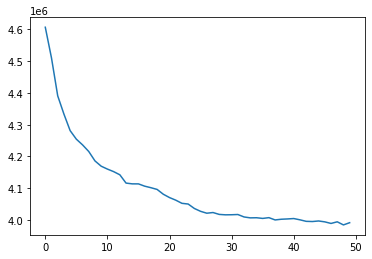

In [9]:
# RMSEs
plt.plot(range(0,50), rmses)

In [10]:
col_added

['full_sq',
 'office_sqm_5000',
 'church_count_500',
 'prom_part_2000',
 'kitch_sq',
 'life_sq',
 'leisure_count_1000',
 'big_church_count_1500',
 'mosque_km',
 'cafe_count_1500_price_1500',
 'office_sqm_1500',
 'cafe_count_5000',
 'office_count_3000',
 'cafe_count_500_price_4000',
 'green_part_2000',
 'build_count_mix',
 'floor',
 'male_f',
 'build_count_1971-1995',
 'num_room',
 'leisure_count_1500',
 'state',
 'fitness_km',
 'hospital_beds_raion',
 'leisure_count_2000',
 'cafe_count_1000_price_500',
 'cafe_count_2000_na_price',
 'cafe_count_3000_price_4000',
 'public_transport_station_min_walk',
 'ttk_km',
 'office_sqm_3000',
 'big_church_km',
 'office_sqm_2000',
 'workplaces_km',
 'green_part_1500',
 'water_km',
 'preschool_quota',
 'catering_km',
 'prom_part_1000',
 'market_count_500',
 'school_quota',
 'office_sqm_1000',
 'cafe_count_5000_price_2500',
 'cafe_avg_price_500',
 'cafe_count_5000_price_1500',
 'radiation_km',
 'trc_sqm_1000',
 'church_count_2000',
 'young_female',
 'b